<a href="https://colab.research.google.com/github/claredavies/DataEngAPITesting/blob/master/AnamolyDetection/HTTP_Response/Semi-Supervised/Monitor_Latency_StatusCode_Semisupervised_LOF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read in Data

In [46]:
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from numpy import where
import seaborn as sns

In [47]:
data = pd.read_csv("Traffic_train.csv")
print(data.head())

   Delay  Code
0  15000   302
1      0   302
2      0   302
3  11000   302
4  19000   302


In [48]:
print(data['Code'].unique())

[302 200 404 400 201 500 204]


In [49]:
data['Code'].value_counts()

200    5918
201     952
400     662
404     314
204     172
500      36
302      35
Name: Code, dtype: int64

In [50]:
one_hot_encoded_data = pd.get_dummies(data, columns = ['Code'])
print(one_hot_encoded_data)

      Delay  Code_200  Code_201  Code_204  Code_302  Code_400  Code_404  \
0     15000         0         0         0         1         0         0   
1         0         0         0         0         1         0         0   
2         0         0         0         0         1         0         0   
3     11000         0         0         0         1         0         0   
4     19000         0         0         0         1         0         0   
...     ...       ...       ...       ...       ...       ...       ...   
8084  13000         1         0         0         0         0         0   
8085  14000         1         0         0         0         0         0   
8086  21000         1         0         0         0         0         0   
8087  15000         1         0         0         0         0         0   
8088  17000         1         0         0         0         0         0   

      Code_500  
0            0  
1            0  
2            0  
3            0  
4            0

In [51]:
df = one_hot_encoded_data[["Delay", "Code_200", "Code_201", "Code_204", "Code_302", "Code_400", "Code_404", "Code_500"]]

# Metrics

In [52]:
def get_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  return cm

def plot_cm(ax,labels, predictions,title, p=0.5):
  tick_labels = ['Y', 'N']
  cm = get_cm(labels, predictions, p)
  sns.heatmap(cm, annot=True, fmt="d",ax=ax)
  ax.title.set_text(title)
  ax.set_xticklabels(tick_labels)
  ax.set_yticklabels(tick_labels)

# Train

In [53]:
model = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.1)
model.fit(df)

LocalOutlierFactor(contamination=0.1, novelty=True)

In [54]:
data2 = pd.read_csv("test.csv")
one_hot_encoded_data2 = pd.get_dummies(data2, columns = ['Code'])
df2 = one_hot_encoded_data2[["Delay", "Code_200", "Code_201", "Code_204", "Code_302", "Code_400", "Code_404", "Code_500","Y"]]

In [55]:
df2

,Delay,Code_200,Code_201,Code_204,Code_302,Code_400,Code_404,Code_500,Y
0,16000,1,0,0,0,0,0,0,1
1,15000,1,0,0,0,0,0,0,1
2,16000,1,0,0,0,0,0,0,1
3,14000,1,0,0,0,0,0,0,1
4,15000,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
6384,19000,1,0,0,0,0,0,0,-1
6385,20000,1,0,0,0,0,0,0,-1
6386,22000,1,0,0,0,0,0,0,-1
6387,23000,1,0,0,0,0,0,0,-1


In [56]:
X_test=df2[["Delay", "Code_200", "Code_201", "Code_204", "Code_302", "Code_400", "Code_404", "Code_500"]]
y_test=df2[["Y"]]

In [57]:

y_pred = model.predict(X_test)
y_pred

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  "X does not have valid feature names, but"


array([1, 1, 1, ..., 1, 1, 1])

# Evaluation

In [58]:
novel_index = where(y_pred == -1) 
novel_values = df2.iloc[novel_index]
novel_values

,Delay,Code_200,Code_201,Code_204,Code_302,Code_400,Code_404,Code_500,Y
6,7000,1,0,0,0,0,0,0,1
19,16000,0,0,0,0,0,1,0,1
38,31000,0,1,0,0,0,0,0,1
46,15000,0,0,1,0,0,0,0,1
112,16000,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...
6369,93000,1,0,0,0,0,0,0,-1
6370,92100,1,0,0,0,0,0,0,-1
6377,34000,1,0,0,0,0,0,0,-1
6378,29500,1,0,0,0,0,0,0,-1


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


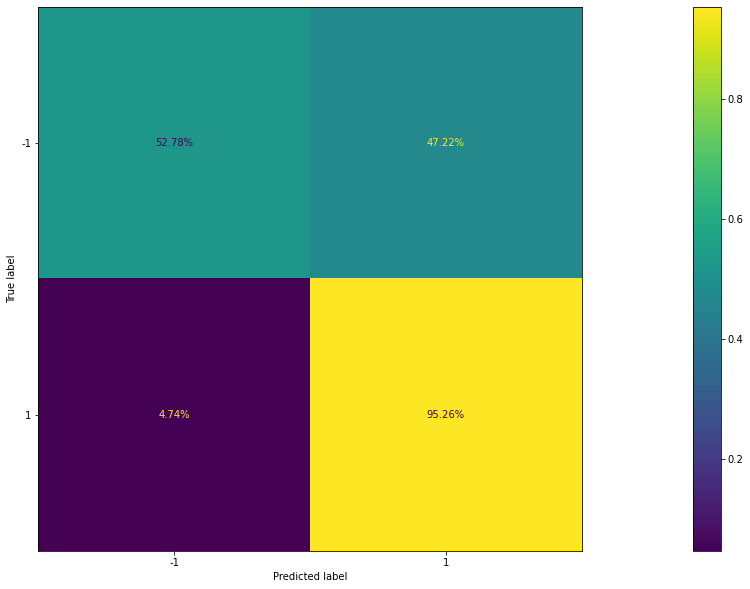

In [62]:
from sklearn.metrics import plot_confusion_matrix
IC = type('IdentityClassifier', (), {"predict": lambda i : i, "_estimator_type": "classifier"})
plot_confusion_matrix(IC, y_pred, y_test, normalize='true', values_format='.2%');


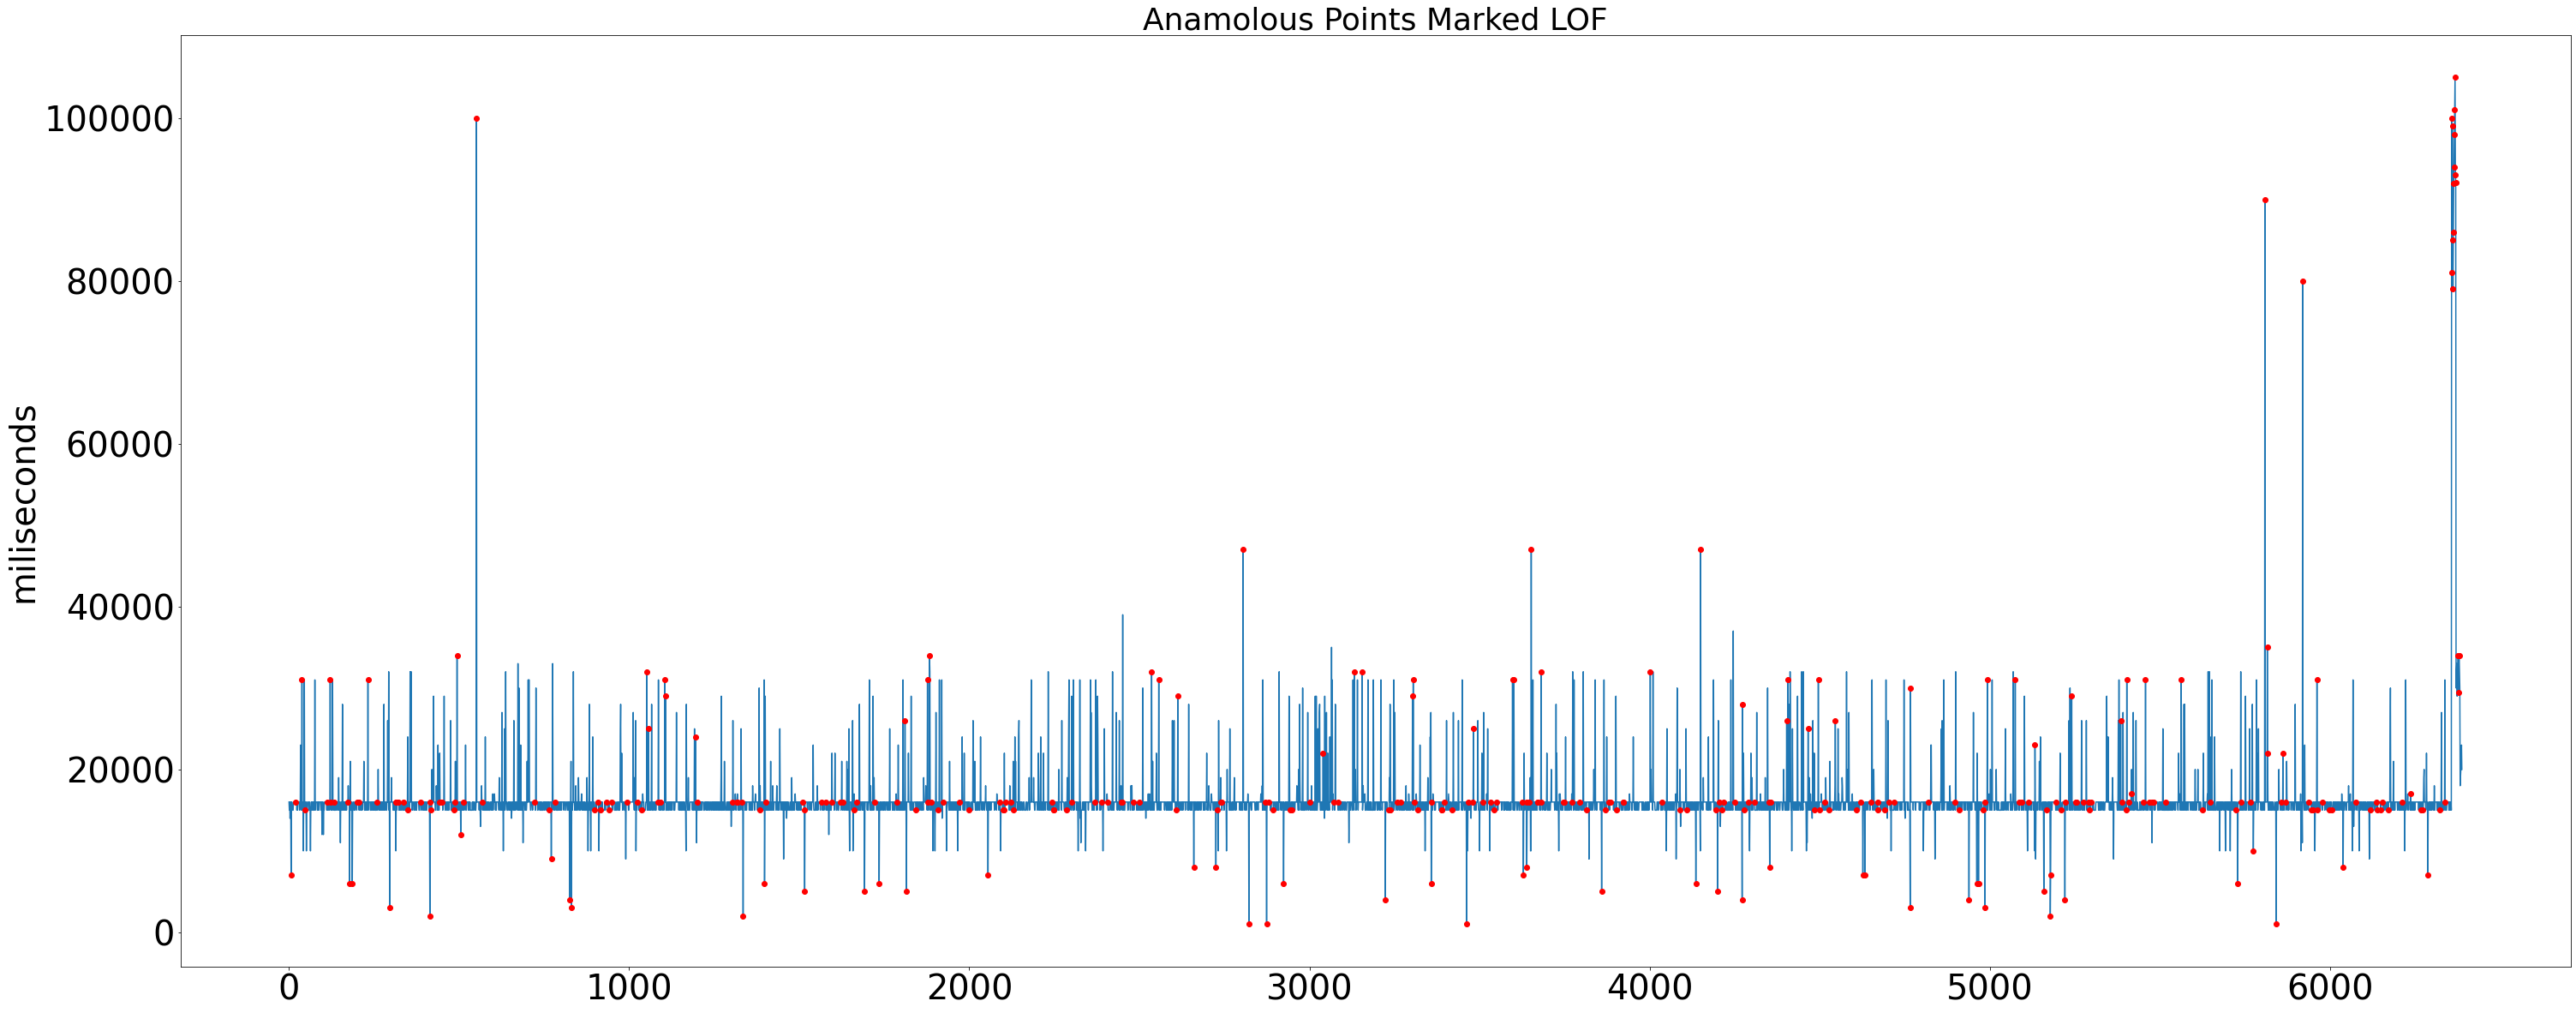

In [79]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (50,20)
plt.plot(df2['Delay'])
plt.rcParams.update({'font.size': 30})
plt.title('Anamolous Points Marked LOF')
plt.plot(df2.iloc[novel_index]['Delay'],"ro")
plt.ylabel('miliseconds')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  "X does not have valid feature names, but"


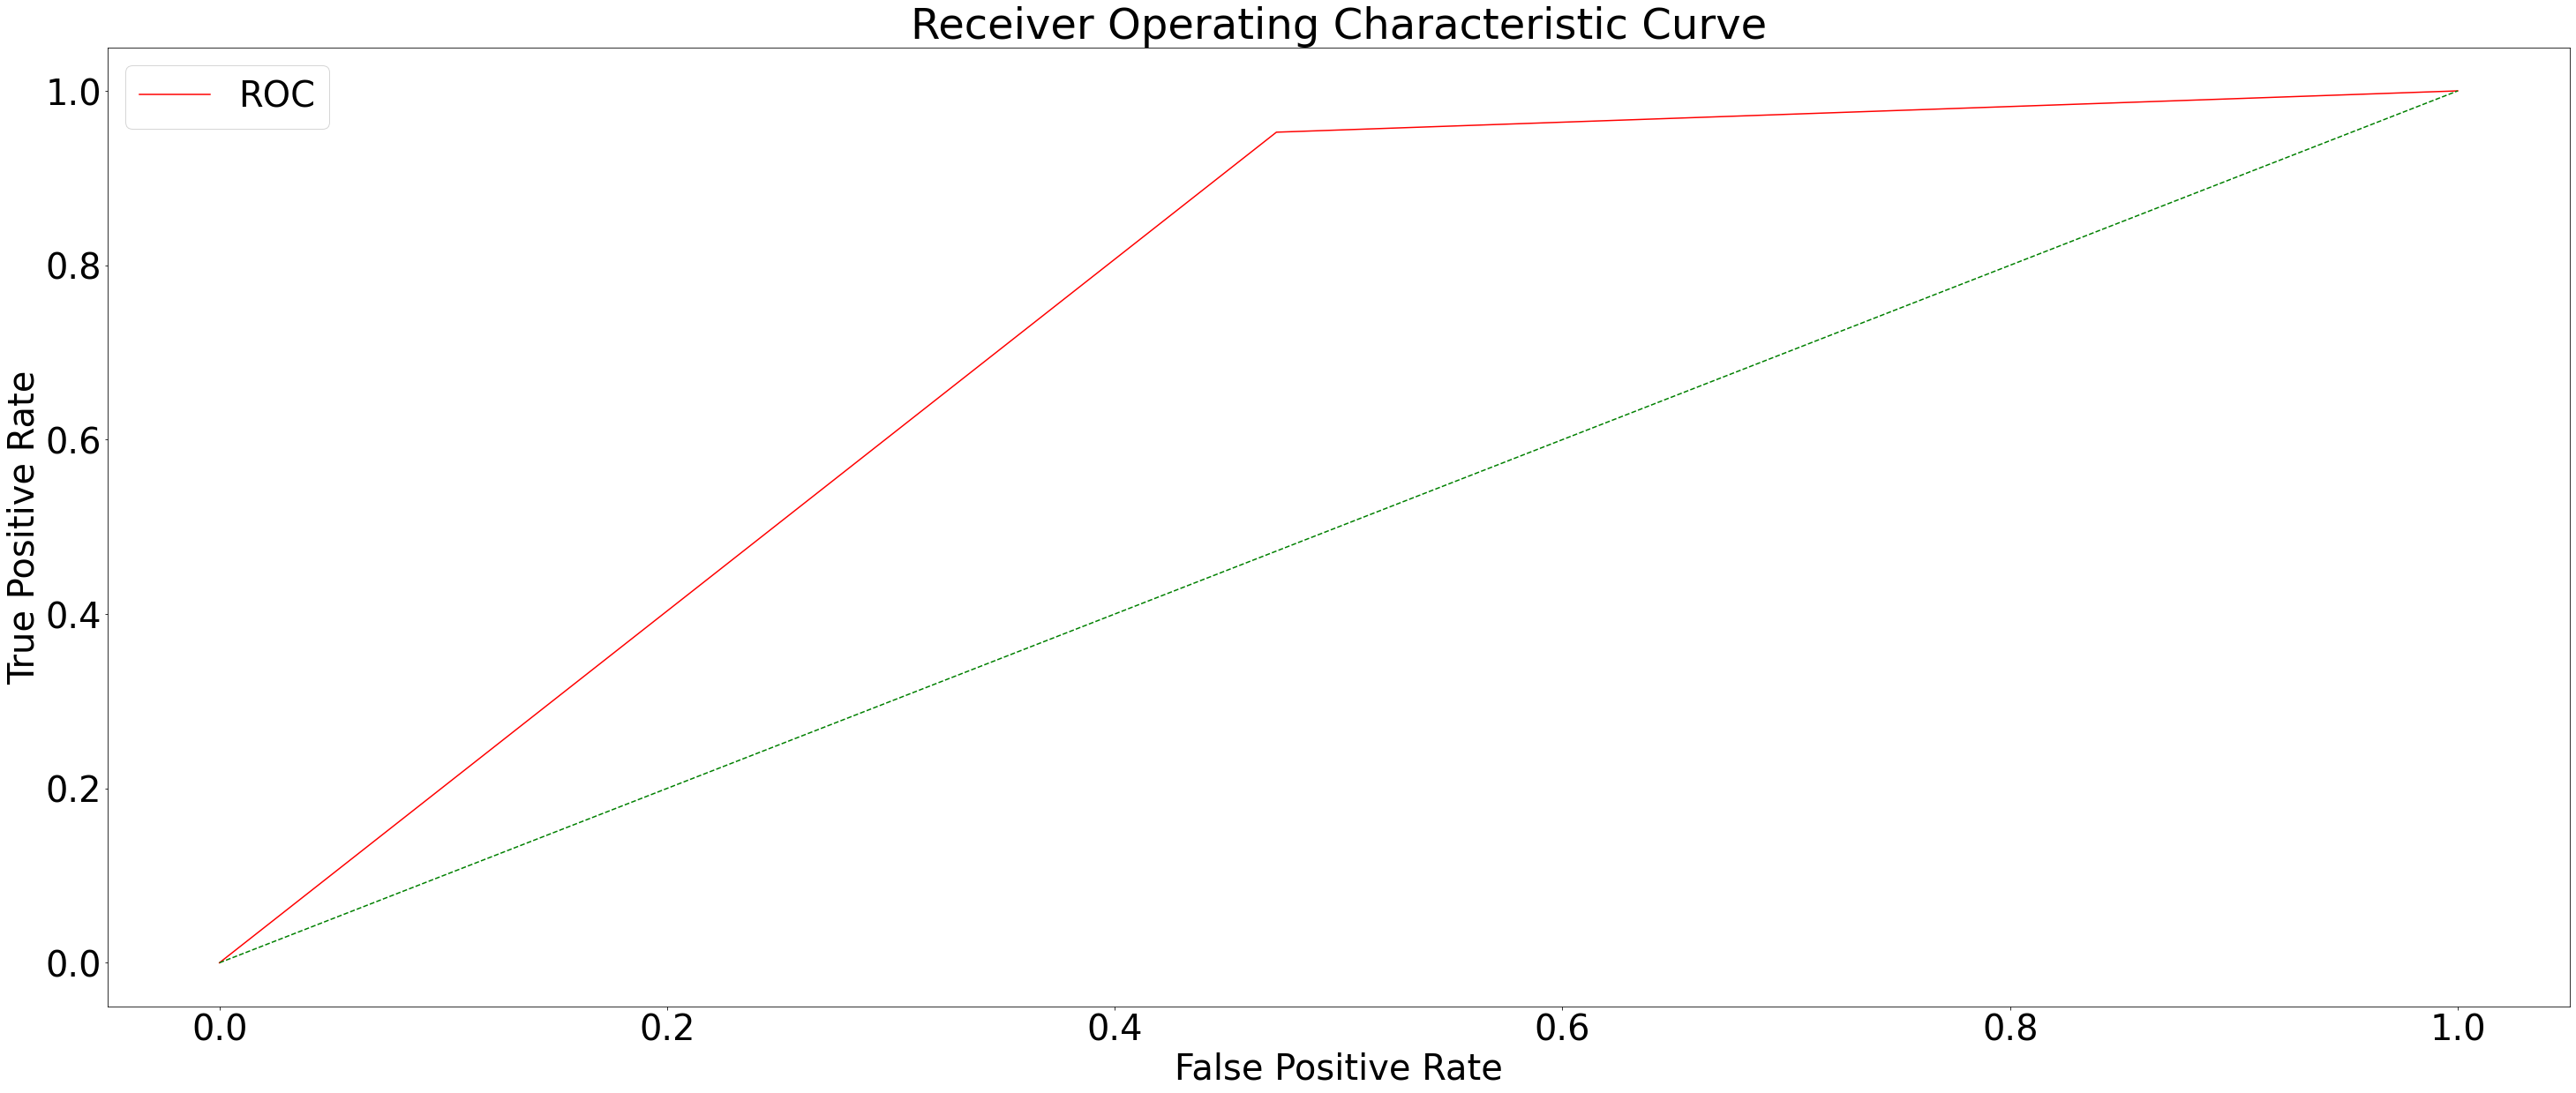

In [78]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
prob = model.predict(X_test)
# prob = probs[:, 1]
fper, tper, thresholds = metrics.roc_curve(y_test, prob)

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.figsize=(10,10)
    plt.legend()
    plt.show()

plot_roc_curve(fper, tper)